In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine

from mpl_toolkits.mplot3d import Axes3D
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

PATH_SENTENCE_TEXT = r"../dataset/concat_sentence_text.csv"

In [2]:
class GloveVectorizer:
    def __init__(self, verbose=False, lowercase=True, remove_stopwords = True, minchars=3):
        
        # load in pre-trained word vectors
        print('Loading word vectors...')
        word2vec = {}
        embedding = []
        idx2word = []
        with open('../glove/glove.6B/glove.6B.50d.txt', encoding = "utf-8") as f:
              # is just a space-separated text file in the format:
              # word vec[0] vec[1] vec[2] ...
              for line in f:
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
                embedding.append(vec)
                idx2word.append(word)
        print('Found %s word vectors.' % len(word2vec))

        self.word2vec = word2vec
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape
        self.verbose = verbose
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.minchars = minchars

    def fit(self, data, *args):
        pass

    def transform(self, data, *args):
        stopwords = list(text.ENGLISH_STOP_WORDS)
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0

        for sentence in data:
            # Note: lower-casing the words
            if self.lowercase & self.remove_stopwords:
                tokens = sentence.lower().split()
                tokens = [word for word in tokens if word not in stopwords]

            else:
                tokens = sentence.split()
                tokens = [word for word in tokens if word not in stopwords]
            vecs = []
            for word in tokens:
                if len(word) >= self.minchars and word in self.word2vec:
                    vec = self.word2vec[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        if self.verbose:
            print("Number of samples with no words found / total: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, X, *args):
        self.fit(X, *args)
        return self.transform(X, *args)

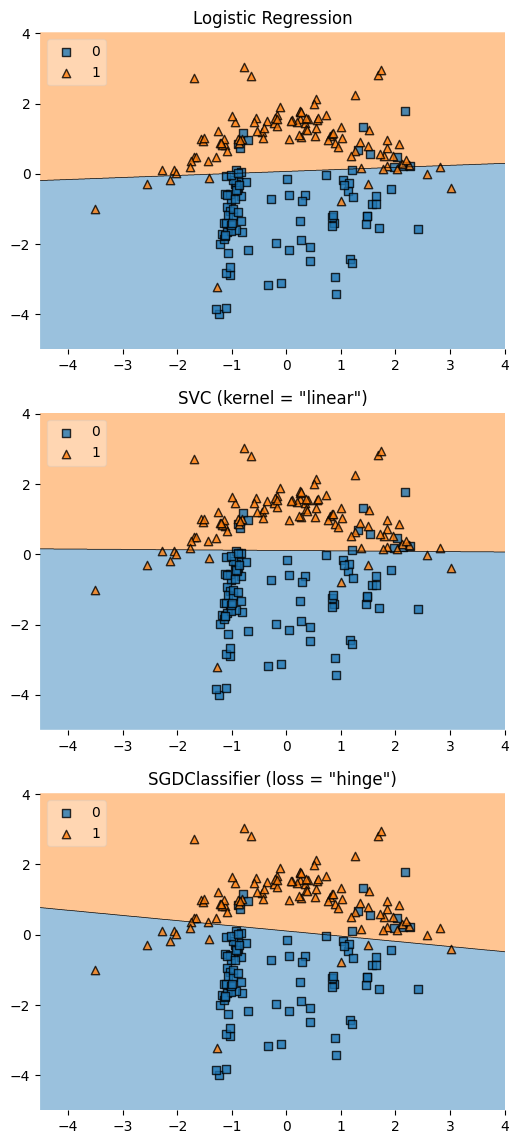

In [25]:
# Visualise decision boundary for classifiers
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=1)

clf1 = LogisticRegression()
clf2 = SVC(kernel="linear")
clf3 = SGDClassifier(loss = "hinge")

gs = gridspec.GridSpec(3, 1)
fig = plt.figure(figsize=(6,14))

labels = ['Logistic Regression', 'SVC (kernel = "linear")', 'SGDClassifier (loss = "hinge")']
for clf, lab, grd in zip([clf1, clf2, clf3],
                         labels,
                         [0, 1, 2]):
 
    clf.fit(X, y)
    # print(grd)
    ax = plt.subplot(gs[grd, 0])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
 
plt.show()

In [2]:
df = pd.read_csv(PATH_SENTENCE_TEXT)

df["sentence_text"] = df["sentence_text"].astype("string")
df["practice"] = df["practice"].astype("string")

# Find top N practices
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")

## Limit to top 10 categories
top_5_cats = list(df_value_counts["practice"][:10])

df = df[df["practice"].isin(top_5_cats)]

In [24]:
top_5_cats

['Identifier_Cookie_or_similar_Tech_1stParty',
 'Contact_E_Mail_Address_1stParty',
 'Location_1stParty',
 'Identifier_Cookie_or_similar_Tech_3rdParty',
 'Identifier_IP_Address_1stParty',
 'Contact_Phone_Number_1stParty',
 'Identifier_Device_ID_1stParty',
 'Contact_Postal_Address_1stParty',
 'SSO',
 'Demographic_Age_1stParty']

### Plots of top 4-grams for all 5 categories

In [17]:
# Df into the 5 different categories first
df_cookie_1stparty = df[df["practice"] == "Identifier_Cookie_or_similar_Tech_1stParty"]
df_email = df[df["practice"] == "Contact_E_Mail_Address_1stParty"]
df_location = df[df["practice"] == "Location_1stParty"]
df_cookie_3rdparty = df[df["practice"] == "Identifier_Cookie_or_similar_Tech_3rdParty"]
df_ip_address = df[df["practice"] == "Identifier_IP_Address_1stParty"]

In [18]:
def get_top_n_4_grams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4, 4), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:title={'center':'Bar chart of 4-grams Frequency for Identifier Cookie 1st Party'}, xlabel='4-gram Words', ylabel='Count'>

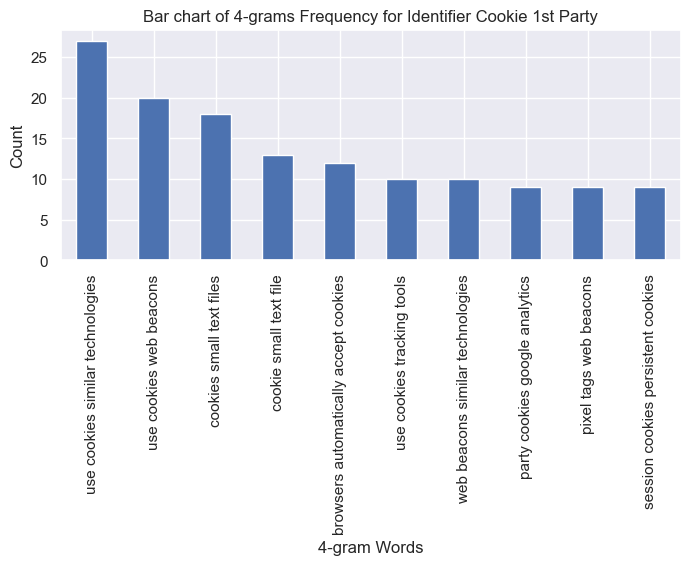

In [19]:
common_words1 = get_top_n_4_grams(df_cookie_1stparty["sentence_text"], 10)
df1 = pd.DataFrame(common_words1, columns = ['Review' , 'Count'])

df1.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,3),
    xlabel = "4-gram Words",
    ylabel = "Count",
    title = "Bar chart of 4-grams Frequency for Identifier Cookie 1st Party"
)

<AxesSubplot:title={'center':'Bar chart of 4-grams Frequency for Contact Email Address 1st Party'}, xlabel='4-gram Words', ylabel='Count'>

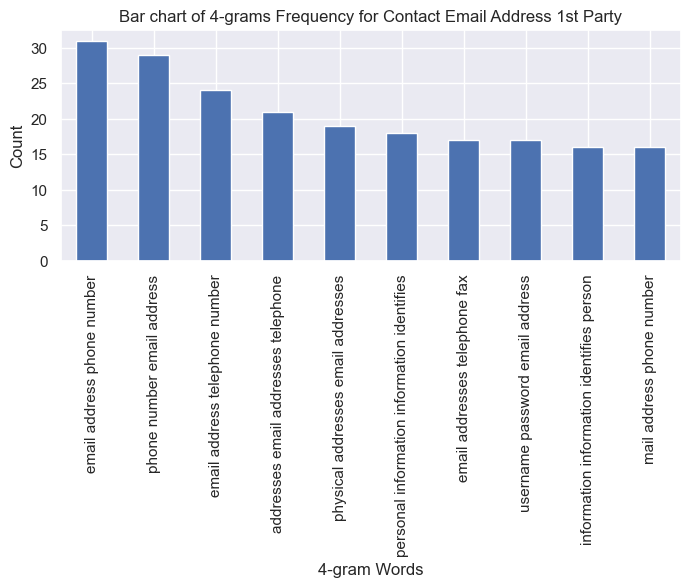

In [20]:
common_words2 = get_top_n_4_grams(df_email["sentence_text"], 10)
df2 = pd.DataFrame(common_words2, columns = ['Review' , 'Count'])

df2.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,3),
    xlabel = "4-gram Words",
    ylabel = "Count",
    title = "Bar chart of 4-grams Frequency for Contact Email Address 1st Party"
)

<AxesSubplot:title={'center':'Bar chart of 4-grams Frequency for Identifier Cookie 3rd Party'}, xlabel='4-gram Words', ylabel='Count'>

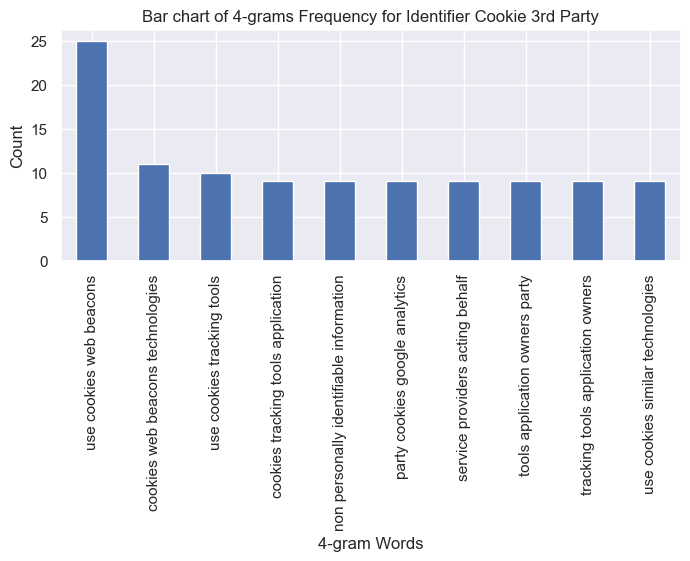

In [21]:
common_words3 = get_top_n_4_grams(df_cookie_3rdparty["sentence_text"], 10)
df3 = pd.DataFrame(common_words3, columns = ['Review' , 'Count'])

df3.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,3),
    xlabel = "4-gram Words",
    ylabel = "Count",
    title = "Bar chart of 4-grams Frequency for Identifier Cookie 3rd Party"
)

<AxesSubplot:title={'center':'Bar chart of 4-grams Frequency for Identifier IP Address'}, xlabel='4-gram Words', ylabel='Count'>

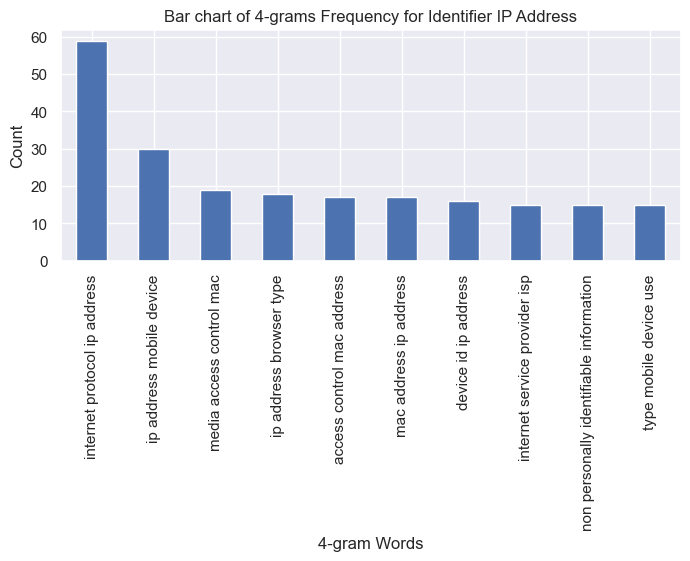

In [22]:
common_words4 = get_top_n_4_grams(df_ip_address["sentence_text"], 10)
df4 = pd.DataFrame(common_words4, columns = ['Review' , 'Count'])

df4.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,3),
    xlabel = "4-gram Words",
    ylabel = "Count",
    title = "Bar chart of 4-grams Frequency for Identifier IP Address"
)

<AxesSubplot:title={'center':'Bar chart of 4-grams Frequency for Location'}, xlabel='4-gram Words', ylabel='Count'>

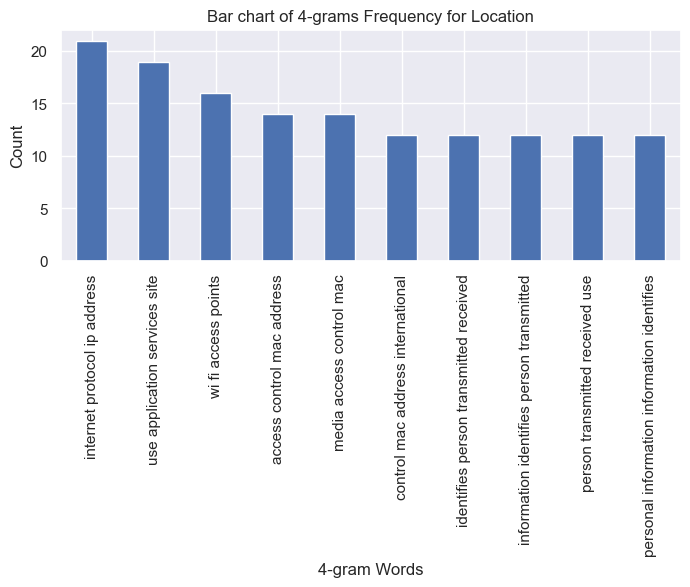

In [23]:
common_words5 = get_top_n_4_grams(df_location["sentence_text"], 10)
df5 = pd.DataFrame(common_words5, columns = ['Review' , 'Count'])

df5.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(8,3),
    xlabel = "4-gram Words",
    ylabel = "Count",
    title = "Bar chart of 4-grams Frequency for Location"
)

#### Other plots

In [3]:
import string

def sentence_length(s) :
    # Removes punctuation
    new_s = s.translate(str.maketrans("", "", string.punctuation))
    return len(new_s.split())

df["sentence_length"] = df["sentence_text"].apply(lambda x: sentence_length(x))

In [4]:
df_summary_stat = df.groupby(by = ["practice"]).describe().reset_index()
df_summary_stat.columns = df_summary_stat.columns.droplevel(0)
df_summary_stat = df_summary_stat.rename(columns = {"":"practice"})

df_summary_stat

,practice,count,mean,std,min,25%,50%,75%,max
0,Contact_E_Mail_Address_1stParty,2106.0,28.033713,20.342864,1.0,16.0,24.0,35.00,369.0
1,Contact_Phone_Number_1stParty,970.0,28.552577,25.814849,1.0,16.0,24.0,35.00,494.0
2,Contact_Postal_Address_1stParty,597.0,28.340034,18.582303,1.0,17.0,25.0,36.00,235.0
3,Demographic_Age_1stParty,428.0,32.413551,32.428477,1.0,17.0,25.0,41.25,494.0
4,Identifier_Cookie_or_similar_Tech_1stParty,2107.0,24.915994,18.874908,1.0,14.0,22.0,31.00,377.0
5,Identifier_Cookie_or_similar_Tech_3rdParty,1250.0,26.700800,16.171075,1.0,17.0,24.0,33.00,204.0
6,Identifier_Device_ID_1stParty,697.0,31.777618,22.720457,1.0,16.0,27.0,42.00,235.0
7,Identifier_IP_Address_1stParty,1005.0,30.288557,19.922967,2.0,16.0,27.0,40.00,204.0
8,Location_1stParty,1514.0,28.496697,23.727196,1.0,15.0,24.0,36.00,369.0
9,SSO,504.0,31.926587,19.863264,1.0,19.0,27.0,40.00,213.0


In [5]:
df_plot = df_summary_stat[["practice", "mean", "50%"]].rename(columns = {"50%":"median"})

df_plot = pd.melt(df_plot, id_vars = ["practice"], value_vars = ["mean", "median"])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Identifier_Cookie_or_similar_Tech_1stParty'),
  Text(1, 0, 'Contact_E_Mail_Address_1stParty'),
  Text(2, 0, 'Location_1stParty'),
  Text(3, 0, 'Identifier_Cookie_or_similar_Tech_3rdParty'),
  Text(4, 0, 'Identifier_IP_Address_1stParty'),
  Text(5, 0, 'Contact_Phone_Number_1stParty'),
  Text(6, 0, 'Identifier_Device_ID_1stParty'),
  Text(7, 0, 'Contact_Postal_Address_1stParty'),
  Text(8, 0, 'SSO'),
  Text(9, 0, 'Demographic_Age_1stParty')])

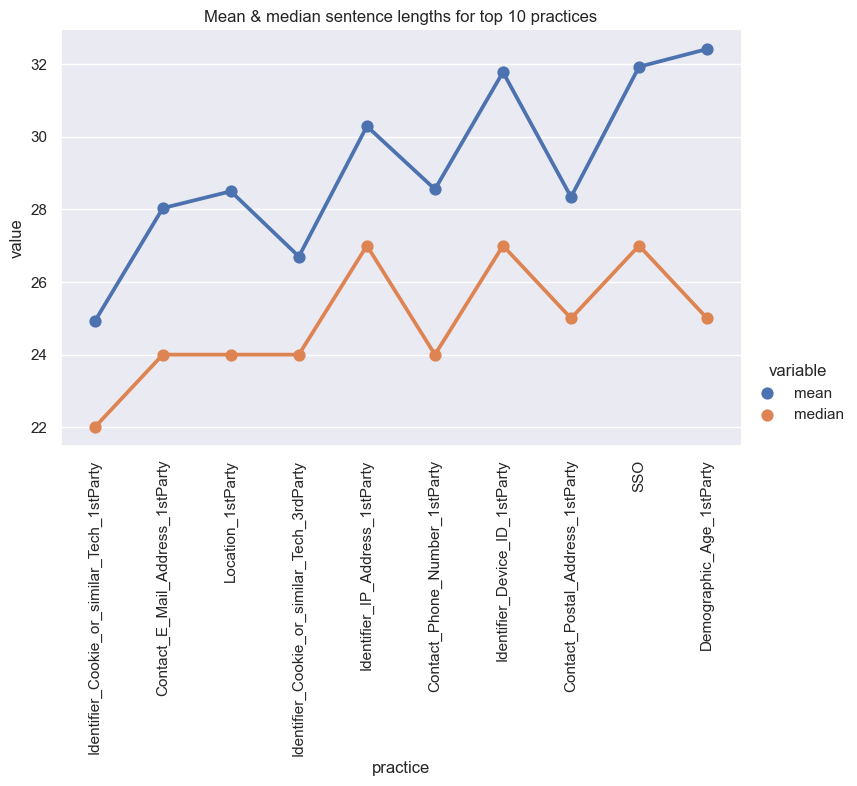

In [79]:
sns.catplot(data = df_plot, x = "practice", y = "value", hue = "variable", order = top_5_cats, kind = "point", height=5, aspect=10/6).set(title = "Mean & median sentence lengths for top 10 practices", )

# plt.set(ylabel = "Sentence length",)
plt.xticks(rotation=90)

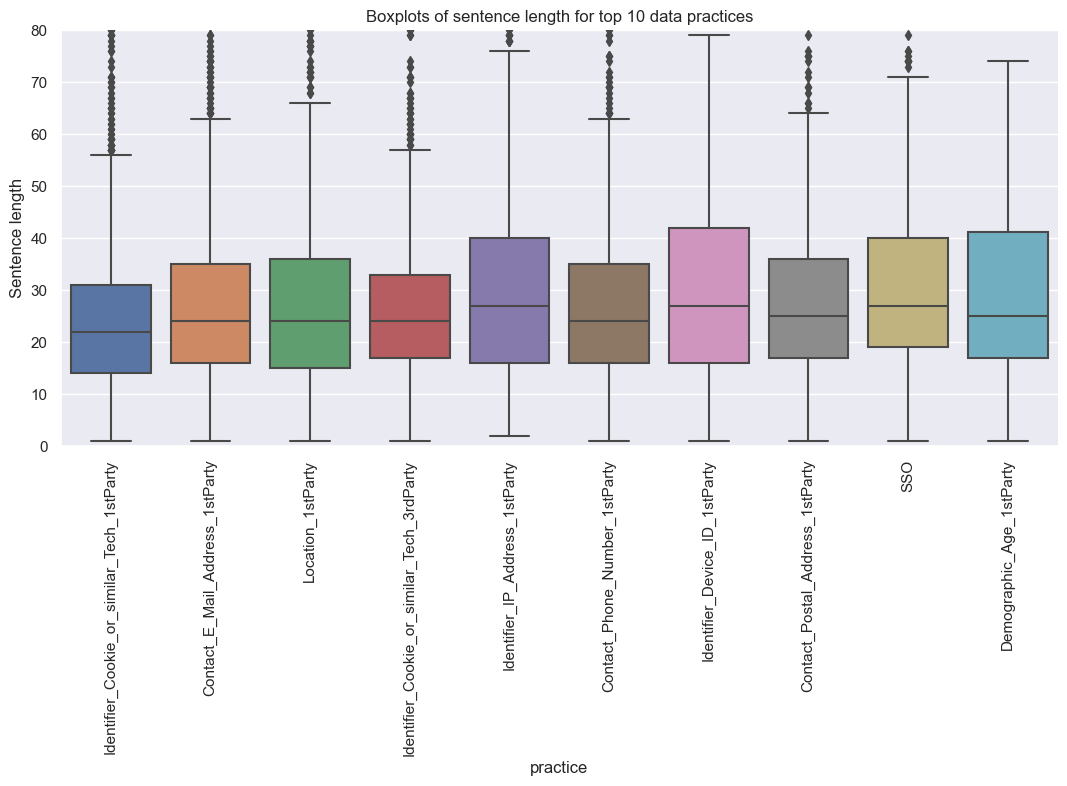

In [50]:
ax = sns.catplot(data=df, x="practice", y="sentence_length", order = top_5_cats, kind = "box", height=5, aspect=14/6)

ax.set(ylabel = "Sentence length", title = "Boxplots of sentence length for top 10 data practices")
plt.ylim(0, 80)
plt.xticks(rotation=90)
plt.show()

(0.0, 100.0)

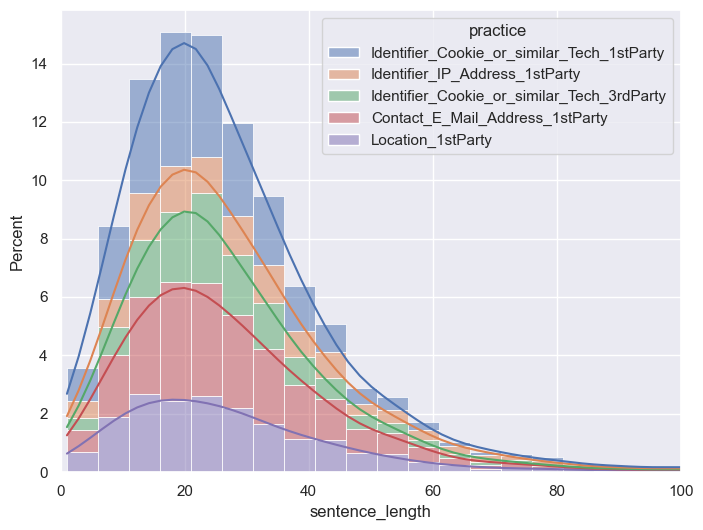

In [48]:
sns.set(rc={'figure.figsize':(8,6)})
fig, ax = plt.subplots()

sns.histplot(data = df[df["practice"].isin(list(df_value_counts["practice"][:5]))], x = "sentence_length", hue = "practice", kde = True, stat = "percent", multiple="stack", binwidth = 5)
ax.set_xlim(0, 100)

(0.0, 100.0)

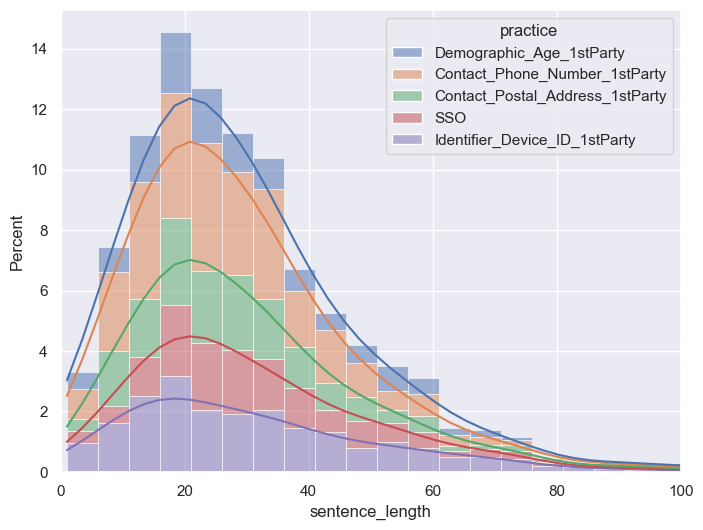

In [51]:
sns.set(rc={'figure.figsize':(8,6)})
fig, ax = plt.subplots()

sns.histplot(data = df[df["practice"].isin(list(df_value_counts["practice"][5:10]))], x = "sentence_length", hue = "practice", kde = True, stat = "percent", multiple="stack", binwidth = 5)
ax.set_xlim(0, 100)